<a href="https://colab.research.google.com/github/prajwalshrestha381/Thinkful_Data_Analytics/blob/main/Python_Capstone_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# **Testing the efficacy of using Price Earnings Ratio and 10-year Treasury rates to maximize returns on S&P 500 index over a medium term horizon.**

Over the past 30 years, the S&P 500 index has delivered a compound average annual growth rate of 10.7% per year. While this a relatively attractive return on investment, the actual returns tend to vary based upon the timing of the investment—e.g., the S&P 500 index delivered a five-year return of -6.6% a year over the five years ending in February 2009, while it delivered a return of 30% a year over the five years ending in July 1987.

Hence, to determine an optimal point of entry Two Sample t-Tests will be conducted using: S&P 500 price earnings ratio (PE Ratio) and year-over-year percentage change in 10-year treasury yield (DGS10) as independent variables, and 5yr forward return on S&P 500 as dependent variable.

The first variable, PE ratio, is selected to test the age-old adage of "Buy low, Sell High." A straight-forward measure calculated by dividing the price by earnings, this ratio acts as a metric showing how expensive the index is with respect to its earnings. 

The second variable, 10-year treasury yield is a closely watched as an indicator of broader investor confidence. The 10-year is used as a proxy for many other important financial matters, such as mortgage rates. This bond also tends to signal investor confidence. The U.S Treasury sells bonds via auction and yields are set through a bidding process. When confidence is high, prices for the 10-year drop, and yields rise. 


The test will be done in three stages; gathering data, cleaning the data, and testing and analyzing the results.



## **1. Gathering and Loading the Data**



### **Setting up all the tools**
First, we need to import all the tools required for this study. Here, we install the API client that will be used to gather data; pandas, numpy, statsmodels and scipy packages for data manipulation and analysis; and matplotlib and seaborn for data visualization.


In [12]:
# Import all packages

!pip install quandl
!pip install termcolor
from termcolor import colored
import quandl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import seaborn as sns
sns.set()
import math
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
import scipy.stats as sp
import os
from datetime import datetime
from scipy.stats import ttest_ind as ttest
from IPython.core.interactiveshell import InteractiveShell
%config InteractiveShell.ast_node_interactivity = 'all'



### **Loading the data**

Now we load the data for the study from two primary sources:
1) Quandl financial database using Quandl API to get PE ratio data and price data for S&P 500.
2) The Federal Reserve Economic System (FRED) database to get the M2 money stock and 10-year Treasury yields. For convenience this data has been downloaded in excel format and loaded to the module. Link to the files is available here:

https://bit.ly/3yaPH17

https://bit.ly/3l672Ex



In [13]:
#mounting data from drive 
from google.colab import drive
drive.mount('/content/gdrive')

# importing data
api_key = os.environ.get("BOT_API_KEY")
quandl.ApiConfig.api_key = api_key
df = quandl.get("MULTPL/SP500_PE_RATIO_MONTH", authtoken="zxh5qxSPXXjvGSrsgmBT")
df["Close"] = quandl.get("MULTPL/SP500_REAL_PRICE_MONTH")
df1 = pd.read_excel (r'/content/gdrive/My Drive/Colab Notebooks/DGS10.xls')


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).



## **2. Cleaning and Preparing the Data for Analysis**

In this step the data from different sources is aggregated into a single dataframe, formatted and cleaned, and prepared for analysis. 



### **Conslidating the data into single dataset**


In [14]:
# Formating the datasets and merging it into one dataframe
df1['Date'] = df1['observation_date']
df.rename(columns={"Value":"PE_Ratio"}, inplace=True)
df.reset_index(inplace=True)
df = pd.merge(df, df1, on ="Date")
df.drop('observation_date', axis=1, inplace=True)
df.head()


,Date,PE_Ratio,Close,DGS10
0,1962-01-01,21.25,69.07,4.083182
1,1962-02-01,21.21,70.22,4.039444
2,1962-03-01,20.86,70.29,3.930455
3,1962-04-01,20.00,68.05,3.843000
4,1962-05-01,18.33,62.99,3.873636



Now that the datasets have been consolidated, we create some calculated columns to test our hypothesis. In that, given that two independent variables the study is testing are continuous they will be converted into categorical variables. PE ratio will be categorized into low PE (PE ratio of less than or equal to 14) and high PE (PE ratio of more than or equal to 22) and the 10-year treasury yields will be categorized into increasing and decreasing regimes. As such, this categorization not only makes the testing possible, but will also provide investors with characteristic market scenarios wherein it is more profitable to invest (if in fact the study finds statistically significant relationship between the respective pairs of independent variables and the dependent variable.)



### **Adding calulated columns for running t-Tests**


In [15]:
# Calculate 5 year forward return
df['five_yr_fr'] =  (df['Close'].shift(-60)-df['Close'])/df['Close'] 

# Convert independent variables into categorical variables
conditions = [
    (df['PE_Ratio']<= 14),
    (df['PE_Ratio'] > 14) & (df['PE_Ratio'] <= 22),
    (df['PE_Ratio'] >22)
]
values = ['low','avg','high']
df['peratio']=np.select(conditions, values)

df['DGS10_yoy_chng'] = df.DGS10.diff(12)
conditions = [
    (df['DGS10_yoy_chng']< 0),
    (df['DGS10_yoy_chng'] > 0)
]
values = ['decreasing','increasing']
df['DGS10_yoy_chng']=np.select(conditions, values)



### **Handling null value**

Missing data, by nature, is problematic. Whenever we’re using our historical data to gain insight, we want to make sure that our sample population is as representative of our actual population as possible. By determining the source of missingness in our datasets, we can more accurately decide how to handle missing values to improve model quality.

Null values generally fall into one of two categories: values that are missing at random, and those values that are not missing at random. Given the nature and source of our initial data, it is complete and there are no missing values. However, as the method of testing here involves calculated columns that look 5 years forward, it inevitably creates null values at the end of dataframe. Hence, we remove these null values. 


In [16]:
# Getting count of null values
print(colored('Looks like we have {} null values'.format(df[df.isnull().any(axis=1)].shape[0]), 'green', attrs=['bold']))

# Removing the null values
df.dropna(inplace=True)

print(colored('Count of null values after cleaning is {}'.format(df[df.isnull().any(axis=1)].shape[0]), 'green', attrs=['bold']))

Looks like we have 60 null values
Count of null values after cleaning is 0



### **Removing outliers**

The final step for preparing the data for analysis involves removing the outliers. The importance of removing the outliers for any statistical analysis cannot be overstated as they tend to significantly skew the results of the study. So, we first calculate the descriptive statistics to gather simple summaries about the sample and the measures, then we identify and remove the outliers using Z score method. As matter of standard practice, only those data points that fall under the 3 standard deviations will be used for the study.


In [17]:
df[['PE_Ratio','DGS10']].describe() 

,PE_Ratio,DGS10
count,655.000000,655.000000
mean,18.948748,6.353002
std,12.116550,2.827341
min,6.790000,1.504000
25%,13.710000,4.207598
50%,17.570000,6.068636
75%,20.735000,7.861158
max,123.730000,15.323810



Looking at the descriptive statistics: we have sufficiently large sample size of 655; and PE_Ratio and DGS10 appear to be relatively normally distributed. Now we further asses the shape and spread of data using histogram.


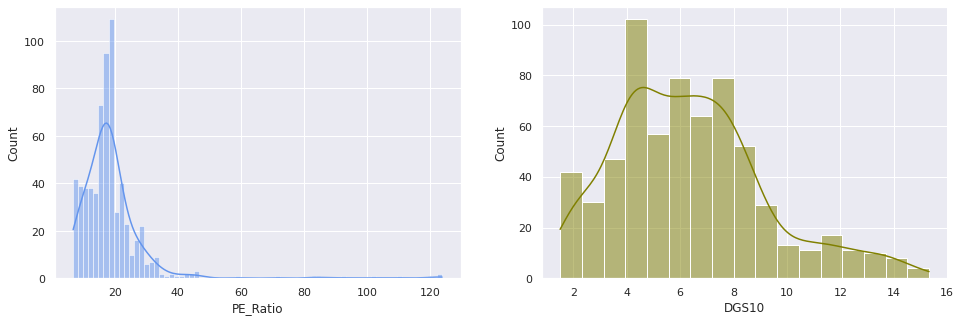

In [18]:
# Check distribution
sns.set(style="darkgrid")

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
sns.histplot(data=df, x="PE_Ratio", kde=True, color="cornflowerblue", ax=ax0)
sns.histplot(data=df, x="DGS10", kde=True, color="olive", ax=ax1)
plt.show()


As discussed above, the histogram plot confirms our prior conclusion of PE_Ratio and DGS10 being relatively normally distributed. Moving on, we use box plot to get a picture of the outliers and then remove the outliers so as to run a more statistically sound test.


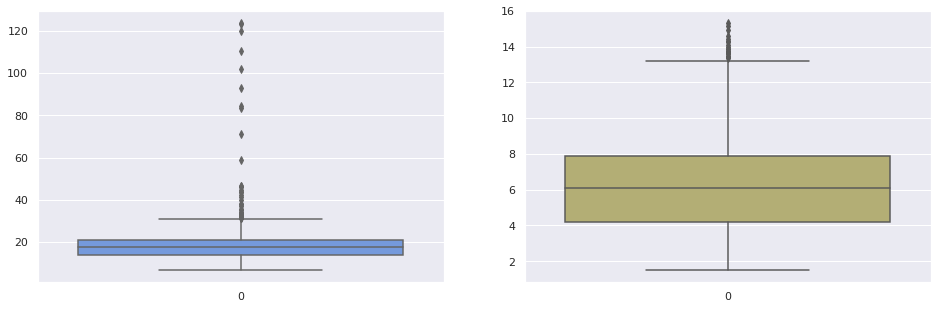

In [19]:
sns.set(style="darkgrid")

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
sns.boxplot(data=df['PE_Ratio'], color = "cornflowerblue", ax =ax0)
sns.boxplot(data=df['DGS10'], color = "darkkhaki", ax =ax1)
plt.show()


As we can see in the boxplots above there are significant number of outliers in the first variable. So, we remove them using the Z score method.


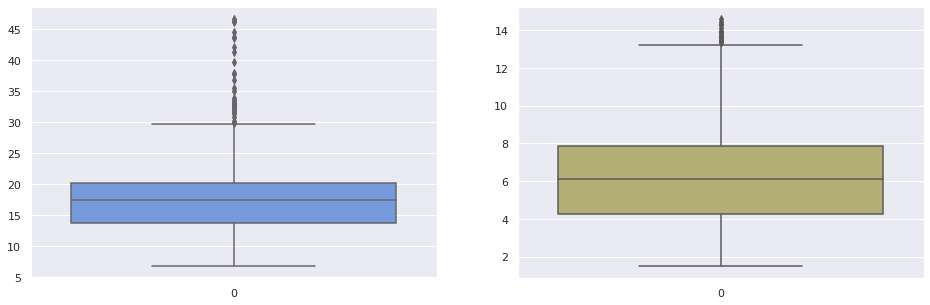

A total of 13 outliers were found and removed


In [20]:
# Remove the outliers
z_scores = stats.zscore(df['PE_Ratio'])
abs_z_scores = np.abs(z_scores)
count1 = df.shape[0]
filtered_entries = (abs_z_scores < 3)
df = df[filtered_entries]

z_scores = stats.zscore(df['DGS10'])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3)
df = df[filtered_entries]
count2 = df.shape[0]

# Get Boxplots for cleaned data
fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
sns.boxplot(data=df['PE_Ratio'], color = "cornflowerblue", ax =ax0)
sns.boxplot(data=df['DGS10'], color = "darkkhaki", ax =ax1)
plt.show()

print(colored('A total of {} outliers were found and removed'.format(count1 - count2), "green", attrs=['bold']))

# Citation
# Title: How to remove outliers from a Pandas DataFrame in Python
# Date: 07/30/2020
# Availability: https://bit.ly/3ycsjQG 

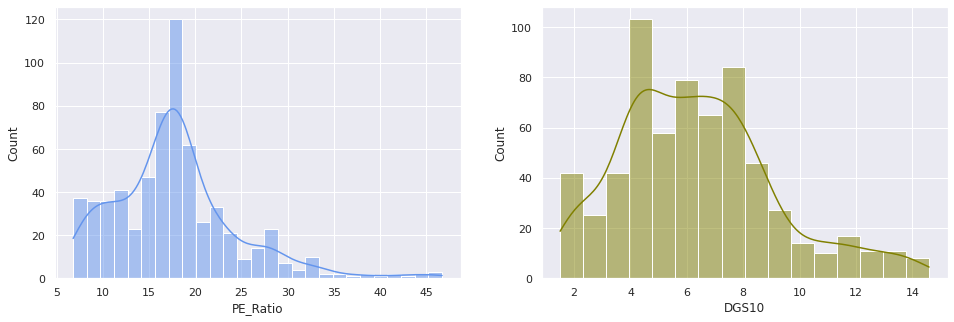

In [21]:
# Check distribution
sns.set(style="darkgrid")

fig, (ax0, ax1) = plt.subplots(nrows=1, ncols=2,figsize=(16, 5))
sns.histplot(data=df, x="PE_Ratio", kde=True, color="cornflowerblue", ax=ax0)
sns.histplot(data=df, x="DGS10", kde=True, color="olive", ax=ax1)
plt.show()


## **3. Two-Sample t-Tests**

Now that we have the data consolidated, cleaned and properly formatted we can run the t-tests. In following section two hypotheses will be tested:

**1.**

**Ho:** The mean 5-year forward return for S&P 500 during low PE ratio = The mean 5-year forward return for S&P 500 during low PE ratio
              
**Ha:** The mean 5-year forward return for S&P 500 during low PE ratio =! The mean 5-year forward return for S&P 500 during low PE ratio

**2.** 

**Ho:** The mean 5-year forward return for S&P 500 during increasing 10-year treasury yield = The mean 5-year forward return for S&P 500 during decreasing 10-year treasury yield

**Ha:** The mean 5-year forward return for S&P 500 during increasing 10-year treasury yield =! The mean 5-year forward return for S&P 500 during decreasing 10-year treasury yield


#### **i) PE Ratio**


,five_yr_fr_low_pe,five_yr_fr_high_pe
count,169.000000,129.000000
mean,0.607101,0.391517
std,0.367904,0.532170


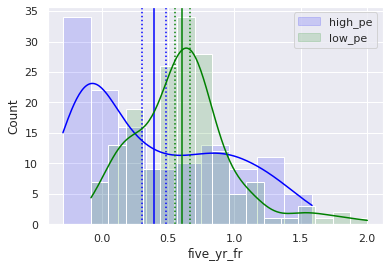

(0.0, 1.0)

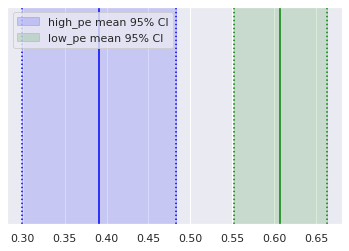

Ttest_indResult(statistic=-3.9384376990449113, pvalue=0.00011060839099163888)

T-statistic is OUSIDE range [-1.96, 1.96], SHOULD reject Ho


In [23]:
# Create two series with 5 yr forward returns during high and low PE ratio
high_pe = df.five_yr_fr[df['peratio'] == 'high']
low_pe = df.five_yr_fr[df['peratio'] == 'low']

pd.merge(low_pe.describe()[['count','mean', 'std']], high_pe.describe()[['count','mean', 'std']], left_index=True, right_index=True, suffixes=('_low_pe', '_high_pe'))

# Calculate stats sample and sample means
high_n = len(high_pe)
high_mean = high_pe.mean()
high_std = high_pe.std()

high_se_of_mean = high_std / math.sqrt(high_n)
high_me_of_mean = 1.96 * high_se_of_mean     # 1.96 for 95% CI; really should be calculated based on df
high_ci_of_mean = ((high_mean - high_me_of_mean), (high_mean + high_me_of_mean))

low_n = len(low_pe)
low_mean = low_pe.mean()
low_std = low_pe.std()

low_se_of_mean = low_std / math.sqrt(low_n)
low_me_of_mean = 1.96 * low_se_of_mean    
low_ci_of_mean = ((low_mean - low_me_of_mean), (low_mean + low_me_of_mean))

#Plot the both samples on the same plot along with their means and the CI's of the means
sns.histplot(high_pe, kde=True, color='blue', alpha=0.15)
plt.axvline(high_mean, color='blue')
plt.axvline(high_ci_of_mean[0], color='blue', linestyle=':')
plt.axvline(high_ci_of_mean[1], color='blue', linestyle=':')

sns.histplot(low_pe, kde=True, color='green', alpha=0.15)
plt.axvline(low_mean, color='green')
plt.axvline(low_ci_of_mean[0], color='green', linestyle=':')
plt.axvline(low_ci_of_mean[1], color='green', linestyle=':')

blue_patch = mpatches.Patch(color='blue', alpha=0.15, label='high_pe')
green_patch = mpatches.Patch(color='green', alpha=0.15, label='low_pe')
plt.legend(handles=[blue_patch, green_patch])

plt.show()

# Closer looks at the CI of difference in means
plt.ylim(0, 1)

plt.axvline(high_mean, color='blue')
plt.axvline(high_ci_of_mean[0], color='blue', linestyle=':')
plt.axvline(high_ci_of_mean[1], color='blue', linestyle=':')
plt.axvspan(high_ci_of_mean[0], high_ci_of_mean[1], color='blue', alpha=0.15)

plt.axvline(low_mean, color='green')
plt.axvline(low_ci_of_mean[0], color='green', linestyle=':')
plt.axvline(low_ci_of_mean[1], color='green', linestyle=':')
plt.axvspan(low_ci_of_mean[0], low_ci_of_mean[1], color='green', alpha=0.15)

blue_patch = mpatches.Patch(color='blue', alpha=0.15, label='high_pe mean 95% CI')
green_patch = mpatches.Patch(color='green', alpha=0.15, label='low_pe mean 95% CI')
plt.legend(handles=[blue_patch, green_patch])

plt.gca().axes.get_yaxis().set_visible(False)

plt.show()

# Run the t-test
result = stats.ttest_ind(high_pe, low_pe, equal_var=False)
print(result)
print()
if (abs(result[0]) > 1.96):  # 1.96 for 95% CI; really should be calculated based on df
    print('T-statistic is OUSIDE range [-1.96, 1.96], SHOULD reject Ho')
else:
    print('T-statistic is INSIDE range [-1.96, 1.96], SHOULD NOT reject Ho')

# Citation
#Title: ttest_ind() Visual Interpretation
#Author: Wade Lykkehoy
#Date: 07/30/2020
#Availability: https://bit.ly/3lh1YgL 





#### **t-Test Conclusion**
The p-value of 0.000109147 is << our alpha of 0.05, which tells us that it is very unlikely to observe Ha if Ho is true. Thus, we reject Ho as the data provides convincing evidence to suggest Ho is wrong.



#### **ii) 10-year Treasury Yield**


,five_yr_fr_increasingDGS10,five_yr_fr_decreasing_DGS10
count,324.000000,306.000000
mean,0.401793,0.516815
std,0.500950,0.478033


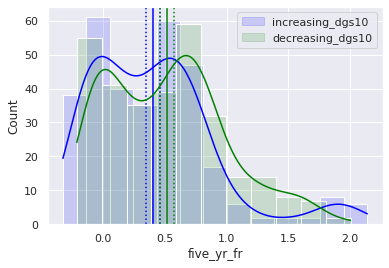

(0.0, 1.0)

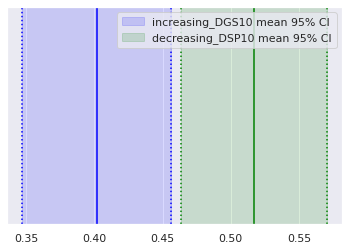

Ttest_indResult(statistic=-2.948966546529199, pvalue=0.003306955345028632)

T-statistic is OUSIDE range [-1.96, 1.96], SHOULD reject Ho


In [ ]:
# Create two series with 5 yr forward returns during high and low PE ratio
increasing_dgs10 = df.five_yr_fr[df['DGS10_yoy_chng'] == 'increasing']
decreasing_dgs10  = df.five_yr_fr[df['DGS10_yoy_chng'] == 'decreasing']


pd.merge(increasing_dgs10.describe()[['count','mean', 'std']], decreasing_dgs10.describe()[['count','mean', 'std']], left_index=True, right_index=True, suffixes=('_increasingDGS10', '_decreasing_DGS10'))

# Calculate stats on sample and sample means
increasing_n = len(increasing_dgs10)
increasing_mean = increasing_dgs10.mean()
increasing_std = increasing_dgs10.std()

increasing_se_of_mean = increasing_std / math.sqrt(increasing_n)
increasing_me_of_mean = 1.96 * increasing_se_of_mean     # 1.96 for 95% CI; really should be calculated based on df
increasing_ci_of_mean = ((increasing_mean - increasing_me_of_mean), (increasing_mean + increasing_me_of_mean))

decreasing_n = len(decreasing_dgs10)
decreasing_mean = decreasing_dgs10.mean()
decreasing_std = decreasing_dgs10.std()

decreasing_se_of_mean = decreasing_std / math.sqrt(decreasing_n)
decreasing_me_of_mean = 1.96 * decreasing_se_of_mean    
decreasing_ci_of_mean = ((decreasing_mean - decreasing_me_of_mean), (decreasing_mean + decreasing_me_of_mean))

#Plot the both samples on the same plot along with their means and the CI's of the means
sns.histplot(increasing_dgs10, kde=True, color='blue', alpha=0.15)
plt.axvline(increasing_mean, color='blue')
plt.axvline(increasing_ci_of_mean[0], color='blue', linestyle=':')
plt.axvline(increasing_ci_of_mean[1], color='blue', linestyle=':')

sns.histplot(decreasing_dgs10, kde=True, color='green', alpha=0.15)
plt.axvline(decreasing_mean, color='green')
plt.axvline(decreasing_ci_of_mean[0], color='green', linestyle=':')
plt.axvline(decreasing_ci_of_mean[1], color='green', linestyle=':')

blue_patch = mpatches.Patch(color='blue', alpha=0.15, label='increasing_dgs10')
green_patch = mpatches.Patch(color='green', alpha=0.15, label='decreasing_dgs10')
plt.legend(handles=[blue_patch, green_patch])

plt.show()

# Closer looks at the CI of difference in means
plt.ylim(0, 1)

plt.axvline(increasing_mean, color='blue')
plt.axvline(increasing_ci_of_mean[0], color='blue', linestyle=':')
plt.axvline(increasing_ci_of_mean[1], color='blue', linestyle=':')
plt.axvspan(increasing_ci_of_mean[0], increasing_ci_of_mean[1], color='blue', alpha=0.15)

plt.axvline(decreasing_mean, color='green')
plt.axvline(decreasing_ci_of_mean[0], color='green', linestyle=':')
plt.axvline(decreasing_ci_of_mean[1], color='green', linestyle=':')
plt.axvspan(decreasing_ci_of_mean[0], decreasing_ci_of_mean[1], color='green', alpha=0.15)

blue_patch = mpatches.Patch(color='blue', alpha=0.15, label='increasing_DGS10 mean 95% CI')
green_patch = mpatches.Patch(color='green', alpha=0.15, label='decreasing_DSP10 mean 95% CI')
plt.legend(handles=[blue_patch, green_patch])

plt.gca().axes.get_yaxis().set_visible(False)

plt.show()

# Run the t-test
result = stats.ttest_ind(increasing_dgs10, decreasing_dgs10, equal_var=False)
print(result)
print()
if (abs(result[0]) > 1.96):  # 1.96 for 95% CI; really should be calculated based on df
    print('T-statistic is OUSIDE range [-1.96, 1.96], SHOULD reject Ho')
else:
    print('T-statistic is INSIDE range [-1.96, 1.96], SHOULD NOT reject Ho')


#### **t-Test Conclusion**
The p-value of 0.00030696 is << our alpha of 0.05, which tells us that it is very unlikely to observe Ha if Ho is true. Thus, we reject Ho as the data provides convincing evidence to suggest Ho is wrong.



## **4. Summary & Recommendations**

#### **When is the optimal time to invest in S&P 500 for investors with 5-year investment horizon?**

Inferring from the results of our t-Tests, we can safely say that investing when S&P 500's PE ratio is low rather than when it high is more likely to yield greater returns.
Similarly, we can also deduce that investing in S&P 500 when 10-year Treasury yield is in a decreasing trend (year-over-year) than when it is in an increasing trend is more likely to return higher returns.
#### **Recommendations:**

Given the conclusion reached, the study would recommend investors invest/invest more when PE ratio is less than or equal to 14 and/or 10-year Treasury yields are decreasing on a year-over-year basis. More specifically, this study provides sufficient evidence against Dollar Cost Averaging (DCA) investment, wherein an investor allocates a set amount of money at regular intervals, usually shorter than a year (monthly or quarterly). Furthermore, it provides strong evidence for lump-sum investing based on PE ratio and trend of 10-year Treasury yields. One can even take it a step further by modifying the DCA and increasing the amount invested while PE ratio is low and/or 10-year Treasury yields are trending lower, and vice-versa.
